In [1]:
# ==========================================
# CELL 1: SETUP & CONFIGURATION
# ==========================================
import os
import zipfile
import cv2
import json
import pandas as pd
import numpy as np
import shutil
import re
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- ⚠️ USER ACTION REQUIRED: CHANGE THIS PATH ---
# Paste the path to your Kaggle Input dataset here
INPUT_ROOT = "/kaggle/input/raf-ce-raw-400" 

# Define filenames (Adjust if your zip/txt files are named differently)
ZIP_FILENAME = "images_400.zip"   # Or "original.zip" if you kept that name
TXT_EMO = "RAFCE_emolabel.txt"
TXT_PART = "RAFCE_partition.txt"
TXT_AU = "RAFCE_AUlabel.txt"

# Define Output Paths (Where we create the new clean data)
WORKING_DIR = "/kaggle/working"
TEMP_EXTRACT = os.path.join(WORKING_DIR, "temp_raw_images")
DIR_LLM = os.path.join(WORKING_DIR, "dataset_llm_336")
DIR_RESNET = os.path.join(WORKING_DIR, "dataset_resnet_224")
JSON_OUTPUT = os.path.join(WORKING_DIR, "train.json")

print("✅ Setup Complete. Ready to start.")

✅ Setup Complete. Ready to start.


In [2]:
# ==========================================
# CELL 2: SMART IMAGE FINDER (REPLACEMENT)
# ==========================================
print("🕵️ Hunting for images in input folder...")

found_dir = None
sample_image = None

# Walk through the entire input directory to find where the images are
for root, dirs, files in os.walk(INPUT_ROOT):
    # Check if this folder contains images (look for png or jpg)
    images = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(images) > 10: # If we find a folder with more than 10 images
        found_dir = root
        sample_image = images[0]
        print(f"✅ FOUND IMAGES IN: {found_dir}")
        print(f"   (Found {len(images)} files. Sample: {sample_image})")
        break

if found_dir:
    SOURCE_IMG_DIR = found_dir
else:
    # If we didn't find images, maybe they are still zipped?
    print("⚠️ No extracted images found. Looking for ZIP...")
    zips = [f for f in os.listdir(INPUT_ROOT) if f.endswith('.zip')]
    if zips:
        # Fallback to unzip logic if zip exists
        zip_path = os.path.join(INPUT_ROOT, zips[0])
        print(f"📦 Found zip: {zip_path}. Unzipping...")
        if os.path.exists(TEMP_EXTRACT):
            shutil.rmtree(TEMP_EXTRACT)
        os.makedirs(TEMP_EXTRACT, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(TEMP_EXTRACT)
        SOURCE_IMG_DIR = TEMP_EXTRACT
    else:
        raise FileNotFoundError("❌ CRITICAL: Could not find any images (.png/.jpg) OR a .zip file!")

print(f"👉 FINAL SOURCE DIRECTORY: {SOURCE_IMG_DIR}")

🕵️ Hunting for images in input folder...
✅ FOUND IMAGES IN: /kaggle/input/raf-ce-raw-400/raf-ce-raw-400/raf-ce-raw-400
   (Found 4908 files. Sample: 2245_aligned.png)
👉 FINAL SOURCE DIRECTORY: /kaggle/input/raf-ce-raw-400/raf-ce-raw-400/raf-ce-raw-400


In [3]:
# ==========================================
# CELL 3: READ LABELS & PREPARE METADATA
# ==========================================
# Helper to read text files from the input directory
def read_txt(filename):
    path = os.path.join(INPUT_ROOT, filename)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {filename} in input folder")
    return path

# 1. Mappings
emotion_map = {
    1: 'Happily surprised', 2: 'Happily disgusted', 3: 'Sadly fearful',
    4: 'Sadly angry', 5: 'Sadly surprised', 6: 'Sadly disgusted',
    7: 'Fearfully angry', 8: 'Fearfully surprised', 9: 'Fearfully disgusted',
    10: 'Angrily surprised', 11: 'Angrily disgusted', 12: 'Disgustedly surprised',
    13: 'Happily fearful', 14: 'Happily sad'
}
# Note: Checks if your txt uses 0-13 or 1-14. Assuming 1-14 based on standard RAF-CE.
# If your friend's code used 0-13, we adjust. 

au_map = {
    1: 'Inner brow raiser', 2: 'Outer brow raiser', 4: 'Brow lowerer', 
    5: 'Upper lid raiser', 6: 'Cheek raiser', 7: 'Lid tightener', 
    9: 'Nose wrinkler', 10: 'Upper lip raiser', 12: 'Lip corner puller',
    15: 'Lip corner depressor', 16: 'Lower lip depressor', 20: 'Lip stretcher',
    23: 'Lip tightener', 25: 'Lips part', 26: 'Jaw drop', 27: 'Mouth stretch'
}

def decode_aus(au_string):
    au_ids = re.findall(r'\d+', str(au_string))
    names = [au_map.get(int(id), "") for id in au_ids]
    names = [n for n in names if n]
    return ", ".join(names) if names else "Neutral expression"

# 2. Load DataFrames
print("📖 Reading Label Files...")
df_emo = pd.read_csv(read_txt(TXT_EMO), sep=r'\s+', header=None, names=['filename', 'emotion_id'])
df_part = pd.read_csv(read_txt(TXT_PART), sep=r'\s+', header=None, names=['filename', 'split_id'])

# Read AU manually
with open(read_txt(TXT_AU), 'r') as f:
    au_lines = f.readlines()
au_data = [{'filename': l.split()[0], 'au_raw': " ".join(l.split()[1:])} for l in au_lines]
df_au = pd.DataFrame(au_data)

# 3. Merge
df = pd.merge(df_emo, df_part, on='filename')
df = pd.merge(df, df_au, on='filename', how='left')

print(f"✅ Metadata Loaded. Total Images: {len(df)}")
display(df.head(3))

📖 Reading Label Files...
✅ Metadata Loaded. Total Images: 4549


,filename,emotion_id,split_id,au_raw
0,0001.jpg,5,0,1+4+25
1,0002.jpg,5,2,4+9+12+25+26+43
2,0003.jpg,10,1,L12+24


In [4]:
# ==========================================
# CELL 4: THE FACTORY (RESIZE & GENERATE JSON)
# ==========================================
print("🏭 Starting Processing Factory...")

os.makedirs(DIR_LLM, exist_ok=True)
os.makedirs(DIR_RESNET, exist_ok=True)

json_data = []
success_count = 0
fail_count = 0

# Scan the actual directory to map filenames (e.g. "train_0001" -> "train_0001_aligned.png")
# This creates a lookup dictionary so we don't care about extensions
print("   Building file index...")
available_files = {}
for f in os.listdir(SOURCE_IMG_DIR):
    # Key = "train_0001" (no extension, no _aligned)
    # Value = "train_0001_aligned.png" (real filename)
    
    clean_name = f.lower().replace("_aligned", "").split('.')[0] # Strip _aligned and extension
    available_files[clean_name] = f

print(f"   Indexed {len(available_files)} images.")

for idx, row in tqdm(df.iterrows(), total=len(df)):
    # 1. Clean the filename from the text file (remove .jpg)
    txt_filename = row['filename'] # e.g., "train_0001.jpg"
    base_name = txt_filename.split('.')[0].replace("test_", "").replace("train_", "") 
    # Note: RAF-CE filenames are sometimes "train_0001.jpg" or just "0001".
    # Let's try to match flexible keys.
    
    # Try exact match first (minus extension)
    key = txt_filename.split('.')[0] 
    
    real_filename = available_files.get(key)
    
    # If not found, try removing "train_" or adding it? 
    # Usually RAF-CE txt has "train_0001.jpg" and file is "train_0001_aligned.jpg"
    # Your key logic in Cell 2 seemed to be: 0001_aligned.png
    
    if not real_filename:
        # Try stripping "train_" prefix if your files are just numbers
        key_simple = key.replace("train_", "").replace("test_", "")
        real_filename = available_files.get(key_simple)

    if not real_filename:
        fail_count += 1
        continue
    
    # 2. Read Image
    img_path = os.path.join(SOURCE_IMG_DIR, real_filename)
    img = cv2.imread(img_path)
    
    if img is None:
        fail_count += 1
        continue
        
    # 3. Resize for Vision-LLM (336x336)
    img_llm = cv2.resize(img, (336, 336), interpolation=cv2.INTER_AREA)
    # Save as JPG to standardize everything
    save_name = key + ".jpg" 
    cv2.imwrite(os.path.join(DIR_LLM, save_name), img_llm)
    
    # 4. Resize for ResNet (224x224)
    img_resnet = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    cv2.imwrite(os.path.join(DIR_RESNET, save_name), img_resnet)
    
    # 5. Build JSON 
    emo_label = emotion_map.get(row['emotion_id'], "Unknown Emotion")
    au_desc = decode_aus(row['au_raw'])
    
    conversation = [
        {
            "from": "human", 
            "value": "<image>\nAnalyze the facial expression. Identify the compound emotion and describe the Action Units."
        },
        {
            "from": "gpt",
            "value": f"The expression is **{emo_label}**. The active Action Units are: {au_desc}."
        }
    ]
    
    json_data.append({
        "id": save_name,
        "image": f"dataset_llm_336/{save_name}", 
        "conversations": conversation
    })
    
    success_count += 1

# Save JSON
with open(JSON_OUTPUT, 'w') as f:
    json.dump(json_data, f, indent=2)

print("\n" + "="*40)
print(f"🎉 PROCESSING DONE!")
print(f"✅ Successfully processed: {success_count} images")
print(f"❌ Failed/Missing:         {fail_count} images")
print("="*40)

🏭 Starting Processing Factory...
   Building file index...
   Indexed 4908 images.


  0%|          | 0/4549 [00:00<?, ?it/s]


🎉 PROCESSING DONE!
✅ Successfully processed: 4549 images
❌ Failed/Missing:         0 images


🕵️ RUNNING SANITY CHECKS...
📂 dataset_llm_336 count:  4549 (Should be ~4549)
📂 dataset_resnet_224 count: 4549 (Should be ~4549)

📄 Checking JSON Format...
First Entry Preview:
{
  "id": "0001.jpg",
  "image": "dataset_llm_336/0001.jpg",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nAnalyze the facial expression. Identify the compound emotion and describe the Action Units."
    },
    {
      "from": "gpt",
      "value": "The expression is **Sadly surprised**. The active Action Units are: Inner brow raiser, Brow lowerer, Lips part."
    }
  ]
}

👁️ Visual Check (Displaying one image from dataset_llm_336)...


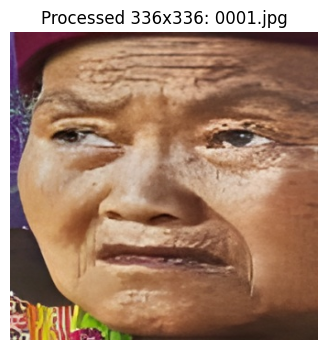

✅ Image dimensions: (336, 336, 3)

✅ IF YOU SEE A FACE ABOVE AND MATCHING COUNTS, YOU ARE READY TO SAVE.


In [5]:
# ==========================================
# CELL 5: VALIDATION & SANITY CHECK (The "Test")
# ==========================================
print("🕵️ RUNNING SANITY CHECKS...")

# 1. Check File Counts
llm_files = len(os.listdir(DIR_LLM))
resnet_files = len(os.listdir(DIR_RESNET))
print(f"📂 dataset_llm_336 count:  {llm_files} (Should be ~{success_count})")
print(f"📂 dataset_resnet_224 count: {resnet_files} (Should be ~{success_count})")

if llm_files < 100:
    print("🚨 ERROR: Too few images. Check the Unzip step!")

# 2. Check JSON Integrity
print("\n📄 Checking JSON Format...")
with open(JSON_OUTPUT, 'r') as f:
    data = json.load(f)
    print(f"First Entry Preview:\n{json.dumps(data[0], indent=2)}")

# 3. Visual Check
print("\n👁️ Visual Check (Displaying one image from dataset_llm_336)...")
sample_img_name = data[0]['image'].split('/')[-1] # Get filename from JSON
sample_path = os.path.join(DIR_LLM, sample_img_name)

if os.path.exists(sample_path):
    img = cv2.imread(sample_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"Processed 336x336: {sample_img_name}")
    plt.axis('off')
    plt.show()
    print(f"✅ Image dimensions: {img.shape}")
else:
    print(f"🚨 ERROR: Sample image {sample_path} not found!")

print("\n✅ IF YOU SEE A FACE ABOVE AND MATCHING COUNTS, YOU ARE READY TO SAVE.")